In [ ]:
import faiss, json, pandas as pd, numpy as np
from pathlib import Path

DATA_DIR = Path("/workspace/data/embeddings")
index = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))

meta = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
assert index.ntotal == len(meta), "Mismatch between vectors and metadata!"
DIM = index.d  # should be 384 for all‑MiniLM‑L6‑v2
print(f"Vectors: {index.ntotal:,} | Dim: {DIM}")


In [ ]:
stats = {
    "vector_count": index.ntotal,
    "dimension": DIM,
    "mean_norm": float(np.mean(np.linalg.norm(index.reconstruct_n(0, index.ntotal), axis=1))),
}

# Optional: include duplication rate only if chunk_sha256 exists
if "chunk_sha256" in meta.columns:
    stats["duplication_rate"] = float(meta["chunk_sha256"].duplicated().mean())
else:
    stats["duplication_rate"] = None  # Mark it missing

# Save JSON
with open(DATA_DIR / "faiss_stats.json", "w") as fp:
    json.dump(stats, fp, indent=2)

stats



In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load all vectors from FAISS
X = np.stack([index.reconstruct(i) for i in range(index.ntotal)])

# Project to 2D
print("Running t-SNE...")
X_2d = TSNE(n_components=2, perplexity=50, init='pca', random_state=42).fit_transform(X)

# Cluster into k groups (can tune this number)
k = 10
print(f"Running k-means with k={k}...")
km = KMeans(n_clusters=k, random_state=42).fit(X)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=km.labels_, cmap='tab10', s=5, alpha=0.7)
plt.title("Knowledge Cluster Map (t-SNE projection)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss

# Load the same model as your embedding pipeline
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Define test queries
queries = [
    "What is order flow imbalance?",
    "Explain the Kelly criterion.",
    "What causes slippage in trade execution?",
    "What is market microstructure?",
    "Define adverse selection in trading.",
]

# Top-k neighbors to retrieve
k = 3

# Run semantic search
for q in queries:
    print("="*120)
    print(f"🔍 Query: {q}")
    q_embed = encoder.encode([q])
    D, I = index.search(q_embed, k)

    for i, idx in enumerate(I[0]):
        row = meta.iloc[idx]
        print(f"\n→ Result {i+1} (score: {D[0][i]:.4f}):")
        print("-"*100)
        print(f"[Source: {row.get('source', 'N/A')} | Page: {row.get('page', 'N/A')}]")
        print(row.get("text_preview", "[No content]"))


In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

# Number of clusters
k = 10

# Re-run k-means to get centroids (if needed)
km = KMeans(n_clusters=k, random_state=42).fit(X)

# Find medoid of each cluster (closest chunk to cluster center)
medoid_idxs, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)

# Print results
cluster_labels = {}

for i, medoid_idx in enumerate(medoid_idxs):
    row = meta.iloc[medoid_idx]
    text = row.get("text_preview", "[No preview]")
    source = row.get("source", "Unknown")
    page = row.get("page", "?")

    print("="*100)
    print(f"🧠 Cluster {i} — Suggested Medoid (chunk #{medoid_idx})")
    print(f"[Source: {source} | Page: {page}]")
    print(f"Preview: {text[:500]}...\n")

    # Optional: manually name it now
    cluster_labels[i] = f"Cluster {i} — [Name me based on above]"



In [ ]:
cluster_labels = {
    0: "Crypto Protocols & Architecture",
    1: "Technical Analysis – Risk Framing",
    2: "Chart Patterns & Price Extremes",
    3: "Quantitative Finance & Simons",
    4: "Options Pricing & Volatility Math",
    5: "Technical Indicators – Reliability",
    6: "Macro Risk Management",
    7: "Market Liquidity & Order Flow",
    8: "ML/Stats in Quant Models",
    9: "Crypto Market Structure & Risks",
}

# Save to CSV for inspection or further mapping
meta["cluster_id"] = km.labels_
meta["cluster_label"] = meta["cluster_id"].map(cluster_labels)
meta.to_csv(DATA_DIR / "metadata_with_clusters.csv", index=False)


In [ ]:
import pandas as pd

# Your full concept list (shortened version shown here)
concepts = [
     # ───── 1. Market Microstructure ─────
    "limit order book",
    "market depth",
    "order book imbalance",
    "order matching engine",
    "price discovery",
    "bid-ask spread",
    "tick size",
    "quote stuffing",
    "market impact",
    "adverse selection",
    "hidden liquidity",
    "latency arbitrage",
    "maker-taker fees",
    "high-frequency trading",
    "flash crash dynamics",
    "order book spoofing",
    "fill probability",
    "queue position",
    "liquidity fragmentation",
    "trading halts",
    "short-term auction effects",

    # ───── 2. Order Flow & Execution ─────
    "execution algorithms",
    "TWAP",
    "VWAP",
    "implementation shortfall",
    "slippage",
    "smart order routing",
    "parent/child order logic",
    "iceberg orders",
    "passive vs aggressive order flow",
    "cancel-replace ratio",
    "execution latency",
    "fill ratio",
    "trade execution certainty",
    "trade sequencing",
    "order flow imbalance",
    "quote-to-trade ratio",
    "multi-leg order routing",

    # ───── 3. Technical & Quant Analysis ─────
    "moving average crossover",
    "relative strength index",
    "macd",
    "bollinger bands",
    "fibonacci retracement",
    "volume profile",
    "trendlines",
    "candlestick reversal patterns",
    "momentum divergence",
    "price action",
    "trend following",
    "mean reversion",
    "chart pattern recognition",
    "indicator lag",
    "supply and demand zones",
    "volume weighted indicators",
    "fractals in price data",

    # ───── 4. Portfolio & Risk Management ─────
    "value at risk",
    "conditional value at risk",
    "maximum drawdown",
    "risk-adjusted return",
    "sharpe ratio",
    "sortino ratio",
    "omega ratio",
    "tail risk",
    "liquidity risk",
    "credit risk",
    "counterparty risk",
    "position sizing",
    "kelly criterion",
    "exposure management",
    "stress testing",
    "scenario analysis",
    "margin risk",
    "portfolio volatility",
    "correlation matrix",
    "beta exposure",
    "concentration risk",
    "regulatory capital",
    "drawdown control",
    "trading halts and kill switches",
    "value decay over drawdowns",
    "stop loss engineering",

    # ───── 5. Psychology & Behavioral Risk ─────
    "loss aversion",
    "confirmation bias",
    "recency bias",
    "overconfidence bias",
    "anchoring bias",
    "emotional trading",
    "overtrading",
    "revenge trading",
    "fear and greed cycles",
    "trader discipline",
    "decision fatigue",
    "mental stop loss",
    "self-sabotage in trading",
    "cognitive dissonance",
    "regret minimization",
    "risk appetite profiling",

    # ───── 6. Crypto Market Structure ─────
    "on-chain liquidity",
    "cex vs dex",
    "impermanent loss",
    "oracle latency",
    "stablecoin depegging risk",
    "MEV (maximal extractable value)",
    "rug pull",
    "slashing risk",
    "smart contract risk",
    "liquidity mining",
    "staking derivatives",
    "yield farming",
    "token vesting cliffs",
    "governance attacks",
    "cross-chain bridge risk",
    "custody vs self custody",
    "flash loan attacks",
    "TVL manipulation",
    "gas fee volatility",
    "proof of reserves",
    "validator concentration risk",
    "exchange insolvency risk",

    # ───── 7. Macroeconomics & Liquidity ─────
    "interest rate risk",
    "yield curve inversion",
    "inflation targeting",
    "quantitative tightening",
    "quantitative easing",
    "federal funds rate",
    "liquidity trap",
    "repo operations",
    "reverse repo facility",
    "dollar liquidity cycles",
    "cross-currency basis swap",
    "USD collateral tightening",
    "global risk-on risk-off",
    "monetary policy divergence",
    "macro liquidity regime shifts",
    "CB balance sheet expansion",
    "eurodollar system",
    "shadow banking system",
    "global USD shortage",

    # ───── 8. Machine Learning & Modeling ─────
    "overfitting",
    "cross-validation",
    "feature importance",
    "hyperparameter tuning",
    "gradient boosting trees",
    "long short-term memory networks",
    "temporal convolutional networks",
    "transformer models for trading",
    "walk forward validation",
    "sliding window retraining",
    "online learning",
    "non-stationary time series",
    "target leakage",
    "ensemble methods",
    "reinforcement learning for trade execution",
    "meta-labeling",
    "probabilistic confidence calibration",
    "covariate shift detection",
    "signal decay tracking",

    # ───── 9. Derivatives & Options ─────
    "option greeks",
    "gamma exposure",
    "delta hedging",
    "theta decay",
    "vega compression",
    "skew arbitrage",
    "implied vs realized volatility",
    "volatility surface modeling",
    "straddle",
    "strangle",
    "covered call",
    "iron condor",
    "volatility term structure",
    "option open interest dynamics",
    "tail hedging",
    "volatility crush",
    "synthetic replication",
    "OTM skew behavior",

    # ───── 10. Regulation, Fraud, Infrastructure Risk ─────
    "insider trading",
    "wash trading",
    "pump and dump",
    "front-running bots",
    "exchange outage risk",
    "flash crash regulation",
    "spoofing and layering",
    "market manipulation",
    "dark pool reporting rules",
    "KYC AML enforcement",
    "regulatory arbitrage",
    "jurisdictional risk",
    "market surveillance",
    "algo trading compliance",
    "post-trade transparency",
    "circuit breaker logic",

    # ───── 11. Meta-Reasoning, Evaluation & Agent Tools ─────
    "reasoning under uncertainty",
    "meta-cognition in strategy switching",
    "confidence scoring",
    "backtest overfitting detection",
    "real vs simulated performance tracking",
    "regime detection",
    "behavioral edge extraction",
    "reward shaping for AI agents",
    "agent burn-in period",
    "decision tree vs ensemble path tracing",
    "multi-agent coordination risk",
    "agent self-correction heuristics"
]

# Convert the list into a DataFrame (like a spreadsheet in memory)
concepts_df = pd.DataFrame({"concept": concepts})

# Save that DataFrame to a .csv file in your /workspace/data folder
concepts_df.to_csv(DATA_DIR / "concept_list.csv", index=False)

print("✅ Your concept list has been saved to /workspace/data/concept_list.csv")


In [ ]:
import os
print(os.listdir(DATA_DIR))


In [ ]:
concepts_df = pd.read_csv(DATA_DIR / "concept_list.csv")
print(concepts_df.head())
print(f"✅ Loaded {len(concepts_df)} concepts from CSV")


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Load concept list from the saved CSV
concepts_df = pd.read_csv(DATA_DIR / "concept_list.csv")
concepts = concepts_df["concept"].tolist()

# Load the encoder model (same as used in embeddings)
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Parameters
threshold = 0.55  # Lower = stricter match
coverage = []

print(f"🔍 Running coverage check on {len(concepts)} concepts...")

for concept in concepts:
    q_embed = encoder.encode([concept])
    D, I = index.search(q_embed, 1)
    dist = D[0][0]
    idx = I[0][0]
    row = meta.iloc[idx]

    is_covered = dist <= threshold
    coverage.append({
        "concept": concept,
        "covered": is_covered,
        "distance": dist,
        "best_chunk": row.get("text_preview", "[No preview]"),
        "source": row.get("source", "Unknown"),
        "page": row.get("page", "?")
    })

# Save results to CSV
coverage_df = pd.DataFrame(coverage)
coverage_df.to_csv(DATA_DIR / "concept_coverage_results.csv", index=False)

# Show top 10 best matches
print("✅ Coverage check complete. Showing top 10 strongest matches:\n")
coverage_df.sort_values("distance").head(10)


In [ ]:
# Show all concepts not confidently covered
missing_df = coverage_df[coverage_df["covered"] == False].sort_values("distance")
missing_df.to_csv(DATA_DIR / "concepts_missing_or_weak.csv", index=False)

print("📄 Exported missing/weak concepts to 'concepts_missing_or_weak.csv'")
missing_df.head(10)


In [ ]:
from pathlib import Path
DATA_DIR = Path("/workspace/data/embeddings")   # same path you used earlier


In [ ]:
import os, pathlib
priority_dir = Path("/workspace/priority_pdfs")   # your real path
print("Files:", os.listdir(priority_dir))


In [ ]:
# ───────────────────────────────────────────────────────────
#  High‑Resolution Re‑Embedding of Priority PDFs
# ───────────────────────────────────────────────────────────
from pathlib import Path
import os, hashlib
import fitz                               # PyMuPDF
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

# ----- paths -----
# main embeddings folder (same as earlier)
DATA_DIR = Path("/workspace/data/embeddings")
# folder where the uploaded PDFs live
priority_dir = Path("/workspace/priority_pdfs")

# ----- discover all PDFs automatically -----
pdf_files = sorted([p for p in priority_dir.glob("*.pdf")])
print("📚 PDFs found for re‑embedding:")
for p in pdf_files:
    print("  •", p.name)

# ----- parameters -----
chunk_size = 350        # smaller chunks = higher resolution
model      = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
vectors    = []
metadata   = []

# ----- process each PDF -----
for pdf_path in pdf_files:
    doc = fitz.open(pdf_path)
    print(f"\n📖 Processing: {pdf_path.name} ({len(doc)} pages)")

    for page_num in range(len(doc)):
        text = doc[page_num].get_text()
        if not text or len(text) < 50:
            continue

        # chunk the page text
        for i in range(0, len(text), chunk_size):
            chunk = text[i : i + chunk_size].strip()
            if len(chunk) < 100:
                continue

            vec = model.encode(chunk).astype(np.float32)
            vectors.append(vec)

            metadata.append({
                "chunk_id"      : hashlib.sha256(chunk.encode()).hexdigest(),
                "text_preview"  : chunk[:400],
                "source"        : pdf_path.name,
                "page"          : page_num + 1,
                "is_priority"   : True
            })

# ----- build & save FAISS index -----
if not vectors:
    raise ValueError("No valid chunks extracted. Check PDF contents.")

dimension = len(vectors[0])
index     = faiss.IndexFlatL2(dimension)
index.add(np.vstack(vectors))

faiss_path      = DATA_DIR / "priority_faiss.index"
metadata_path   = DATA_DIR / "priority_metadata.csv"

faiss.write_index(index, str(faiss_path))
pd.DataFrame(metadata).to_csv(metadata_path, index=False)

print("\n✅ High‑resolution index & metadata saved:")
print("   •", faiss_path)
print("   •", metadata_path)
print("   • Chunks embedded:", len(vectors))



In [ ]:
from sentence_transformers import SentenceTransformer
import faiss, pandas as pd

encoder         = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
main_index      = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))
priority_index  = faiss.read_index(str(DATA_DIR / "priority_faiss.index"))

meta_main       = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
meta_priority   = pd.read_csv(DATA_DIR / "priority_metadata.csv")


In [ ]:
def semantic_search(query, k=5, boost=0.10):
    q_vec = encoder.encode([query])
    
    # 1) priority search
    Dp, Ip = priority_index.search(q_vec, k)
    results = []
    for d, i in zip(Dp[0], Ip[0]):
        score = (1 - d) + boost           # give priority chunks extra weight
        row   = meta_priority.iloc[i]
        results.append(("priority", score, row))
    
    # 2) main search (fill remaining slots)
    if len(results) < k:
        Dm, Im = main_index.search(q_vec, k - len(results))
        for d, i in zip(Dm[0], Im[0]):
            score = (1 - d)               # normal score
            row   = meta_main.iloc[i]
            results.append(("main", score, row))
    
    # sort by final score descending
    results.sort(key=lambda x: -x[1])
    return results[:k]


In [ ]:
hits = semantic_search("explain liquidity risk", k=5, boost=0.10)

for src, score, row in hits:
    print(f"[{src}] {score:.3f} | {row['source']} p.{row['page']}")
    print("   ", row['text_preview'][:140], "...\n")


In [ ]:
# ──────────────────────────────────────────────────────
#  Priority‑First Concept Coverage Scan
# ──────────────────────────────────────────────────────
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss, numpy as np

# 1.  Load concept list
concepts     = pd.read_csv(DATA_DIR / "concept_list.csv")["concept"].tolist()

# 2.  Load indices & metadata
encoder         = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
priority_index  = faiss.read_index(str(DATA_DIR / "priority_faiss.index"))
main_index      = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))
meta_priority   = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main       = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")

def hybrid_search(vec, k=1, boost=0.10):
    # priority first
    Dp, Ip = priority_index.search(vec, k)
    best_d, best_i, best_src = Dp[0][0], Ip[0][0], "priority"
    best_score = (1 - best_d) + boost
    
    # main fallback
    Dm, Im = main_index.search(vec, 1)
    alt_d, alt_i = Dm[0][0], Im[0][0]
    alt_score    = (1 - alt_d)
    
    # choose highest score
    if alt_score > best_score:
        return "main", alt_d, alt_i
    else:
        return best_src, best_d, best_i

results = []
threshold = 0.65   # keep same threshold

for concept in concepts:
    q_vec = encoder.encode([concept])
    src, dist, idx = hybrid_search(q_vec, k=1, boost=0.10)
    
    row = meta_priority.iloc[idx] if src == "priority" else meta_main.iloc[idx]
    covered = dist <= threshold
    
    results.append({
        "concept"   : concept,
        "covered"   : covered,
        "distance"  : dist,
        "source"    : row["source"],
        "page"      : row["page"],
        "priority?" : src == "priority"
    })

coverage_df = pd.DataFrame(results)
coverage_df.to_csv(DATA_DIR / "concept_coverage_priority_first.csv", index=False)

print("✅ Scan complete.  Missing / weak concepts:")
missing = coverage_df[coverage_df["covered"] == False].sort_values("distance")
display(missing.head(20))


In [7]:
# ───────── Incremental re‑embed of priority_pdfs ─────────
from pathlib import Path
import fitz, hashlib, faiss, numpy as np, pandas as pd
from sentence_transformers import SentenceTransformer

# 1. Paths
DATA_DIR      = Path("/workspace/data/embeddings")          # main data folder
priority_dir  = Path("/workspace/priority_pdfs")            # folder with PDFs
index_path    = DATA_DIR / "priority_faiss.index"
meta_path     = DATA_DIR / "priority_metadata.csv"

# 2. Load existing index & metadata (if present)
if index_path.exists():
    priority_index = faiss.read_index(str(index_path))
    meta_df        = pd.read_csv(meta_path)
    existing_sha   = set(meta_df["chunk_id"])
    print(f"📚 Existing chunks: {len(meta_df)}")
else:
    priority_index = None
    meta_df        = pd.DataFrame()
    existing_sha   = set()
    print("📚 No existing priority index found – fresh start.")

# 3. Parameters
chunk_size = 350
model      = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 4. Walk through PDFs and collect NEW chunks
vectors, new_meta = [], []
for pdf_path in priority_dir.glob("*.pdf"):
    doc = fitz.open(pdf_path)
    print(f"🔍 Scanning {pdf_path.name} ({len(doc)} pages)")

    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text")
        if not text: 
            continue
        for i in range(0, len(text), chunk_size):
            chunk = text[i:i+chunk_size].strip()
            if len(chunk) < 100:             # skip tiny fragments
                continue
            sha = hashlib.sha256(chunk.encode()).hexdigest()
            if sha in existing_sha:          # already embedded
                continue
            vectors.append(model.encode(chunk).astype(np.float32))
            new_meta.append({
                "chunk_id"     : sha,
                "text_preview" : chunk[:400],
                "source"       : pdf_path.name,
                "page"         : page_num + 1,
                "is_priority"  : True
            })

# 5. Add new vectors to FAISS and save
if vectors:
    vecs_np = np.vstack(vectors)
    if priority_index is None:                      # first‑time build
        priority_index = faiss.IndexFlatL2(vecs_np.shape[1])
    priority_index.add(vecs_np)

    faiss.write_index(priority_index, str(index_path))
    meta_df = pd.concat([meta_df, pd.DataFrame(new_meta)], ignore_index=True)
    meta_df.to_csv(meta_path, index=False)

    print(f"\n✅ Added {len(vectors)} new chunks "
          f"from {len(set(m['source'] for m in new_meta))} new PDF(s).")
    print("   Total priority chunks:", len(meta_df))
else:
    print("\n✅ No new chunks detected. Priority index already up‑to‑date.")


📚 Existing chunks: 37419
🔍 Scanning ChatGPT Advanced Trading Handbook.pdf (34 pages)
🔍 Scanning Candlestick Trading Technique- Trade Trend Reversal with Pin -- Avinash Mudaliar -- 2017.pdf (17 pages)
🔍 Scanning Optimal trading strategies - quantitative approaches for -- Robert Kissell; Morton Glantz; Roberto Malamut -- 1st, First Edition, PS, 2003.pdf (408 pages)
🔍 Scanning Encyclopedia of Candlestick Charts (Wiley Trading) -- Thomas N_ Bulkowski, Thomas N_ Bulkowski -- Wiley trading series, Hoboken, N_J, New Jersey, 2008.pdf (966 pages)
🔍 Scanning Advances in Financial Machine Learning by López de Prado, Marcos -- 2018 .pdf (393 pages)
🔍 Scanning Clearing, settlement, and custody -- David Loader -- 3, 2019 -- Butterworth-Heinemann, an imprint of Elsevier.pdf (331 pages)
🔍 Scanning Mastering blockchain - unlocking the power of -- Lorne Lantz, Daniel Cawrey -- 1, 2020-12-08 -- O'Reilly Media, Incorporated; O'Reilly Media.pdf (0 pages)
🔍 Scanning GPT TA nuance.pdf (8 pages)
🔍 Scanning T

In [9]:
# reload fresh metadata because we appended new chunks
meta_priority = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main     = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")

# ────────────────────────────────────────────────────────────────
# Concept‑coverage scan  — priority‑first   (threshold = 0.65)
# ────────────────────────────────────────────────────────────────
from sentence_transformers import SentenceTransformer
import pandas as pd, faiss
from pathlib import Path

# ---------- paths & basic objects ----------
DATA_DIR = Path("/workspace/data/embeddings")
encoder  = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
threshold = 0.7

# ---------- load indices ----------
priority_index = faiss.read_index(str(DATA_DIR / "priority_faiss.index"))
main_index     = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))

# ---------- reload metadata to match latest index sizes ----------
meta_priority  = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main      = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")

assert priority_index.ntotal == len(meta_priority),  \
    f"Priority index ({priority_index.ntotal}) vs metadata rows ({len(meta_priority)}) mismatch"
assert main_index.ntotal == len(meta_main),          \
    f"Main index ({main_index.ntotal}) vs metadata rows ({len(meta_main)}) mismatch"

# ---------- load concept list ----------
concepts = pd.read_csv(DATA_DIR / "concept_list.csv")["concept"].tolist()

# ---------- scan ----------
coverage = []
for concept in concepts:
    q_vec = encoder.encode([concept])

    # 1️⃣  priority search
    Dp, Ip = priority_index.search(q_vec, 1)
    best_dist   = Dp[0][0]
    best_row    = meta_priority.iloc[Ip[0][0]]
    is_prior    = True

    # 2️⃣  main search (if closer)
    Dm, Im = main_index.search(q_vec, 1)
    if Dm[0][0] < best_dist:
        best_dist = Dm[0][0]
        best_row  = meta_main.iloc[Im[0][0]]
        is_prior  = False

    coverage.append({
        "concept"   : concept,
        "covered"   : best_dist <= threshold,
        "distance"  : best_dist,
        "source"    : best_row["source"],
        "page"      : best_row["page"],
        "priority?" : is_prior
    })

coverage_df = pd.DataFrame(coverage)
coverage_df.to_csv(DATA_DIR / "concept_coverage_0p65.csv", index=False)

print("✅ Scan complete. Missing / weak concepts:")
display(
    coverage_df[~coverage_df["covered"]]
      .sort_values("distance")
      .head(25)        # show top 25 weakest
)



✅ Scan complete. Missing / weak concepts:


,concept,covered,distance,source,page,priority?
141,hyperparameter tuning,False,0.700681,Advances in Financial Machine Learning by Lóp...,156,True
2,order book imbalance,False,0.704797,Pairs trading quantitative methods and analysi...,7,False
58,risk-adjusted return,False,0.706274,risk management and financial institutions.pdf,30,True
124,federal funds rate,False,0.709421,Candlestick and pivot point trading triggers -...,321,True
67,kelly criterion,False,0.710415,The Art and Science of Technical Analysis- Mar...,181,True
38,moving average crossover,False,0.713070,Candlestick and pivot point trading triggers -...,171,True
54,fractals in price data,False,0.731790,The Art and Science of Technical Analysis- Mar...,74,True
128,dollar liquidity cycles,False,0.736547,The Financial Mathematics of Market Liquidity-...,294,True
81,loss aversion,False,0.737465,Unknown,0,False
123,quantitative easing,False,0.738559,PrinciplesofMacroeconomics-LR.pdf,442,False


In [12]:
# --- Cluster (re)labelling helper ------------------------------------
import numpy as np, pandas as pd, faiss
from sklearn.cluster import KMeans

# reload fresh metadata & vectors
meta_priority = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main     = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
vectors_main  = main_index.reconstruct_n(0, main_index.ntotal)
vectors_prio  = priority_index.reconstruct_n(0, priority_index.ntotal)
X             = np.vstack([vectors_main, vectors_prio])

# step 1: K‑means (reuse same k as before, e.g. k=10)
k = 10
km = KMeans(n_clusters=k, random_state=42).fit(X)
cluster_ids = km.labels_

# step 2: attach back to metadata
meta_all = pd.concat([meta_main, meta_priority], ignore_index=True)
meta_all["cluster_id"] = cluster_ids

# optional: human‑readable labels (reuse your dict or define anew)
cluster_labels = {
    0: "Crypto & DeFi",
    1: "Technical Analysis",
    2: "Chart Patterns",
    3: "Quant Finance / Simons",
    4: "Options & Vol",
    5: "Indicators",
    6: "Macro Risk",
    7: "Market Liquidity",
    8: "ML / Stats",
    9: "Crypto Market Struct"
}
meta_all["cluster_label"] = meta_all["cluster_id"].map(cluster_labels)

# split back into separate CSVs
meta_main      = meta_all.iloc[:len(meta_main)].copy()
meta_priority  = meta_all.iloc[len(meta_main):].copy()

meta_main.to_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv", index=False)
meta_priority.to_csv(DATA_DIR / "priority_metadata.csv", index=False)

print(f"✅ Cluster labels assigned and saved.  k = {k}")


✅ Cluster labels assigned and saved.  k = 10


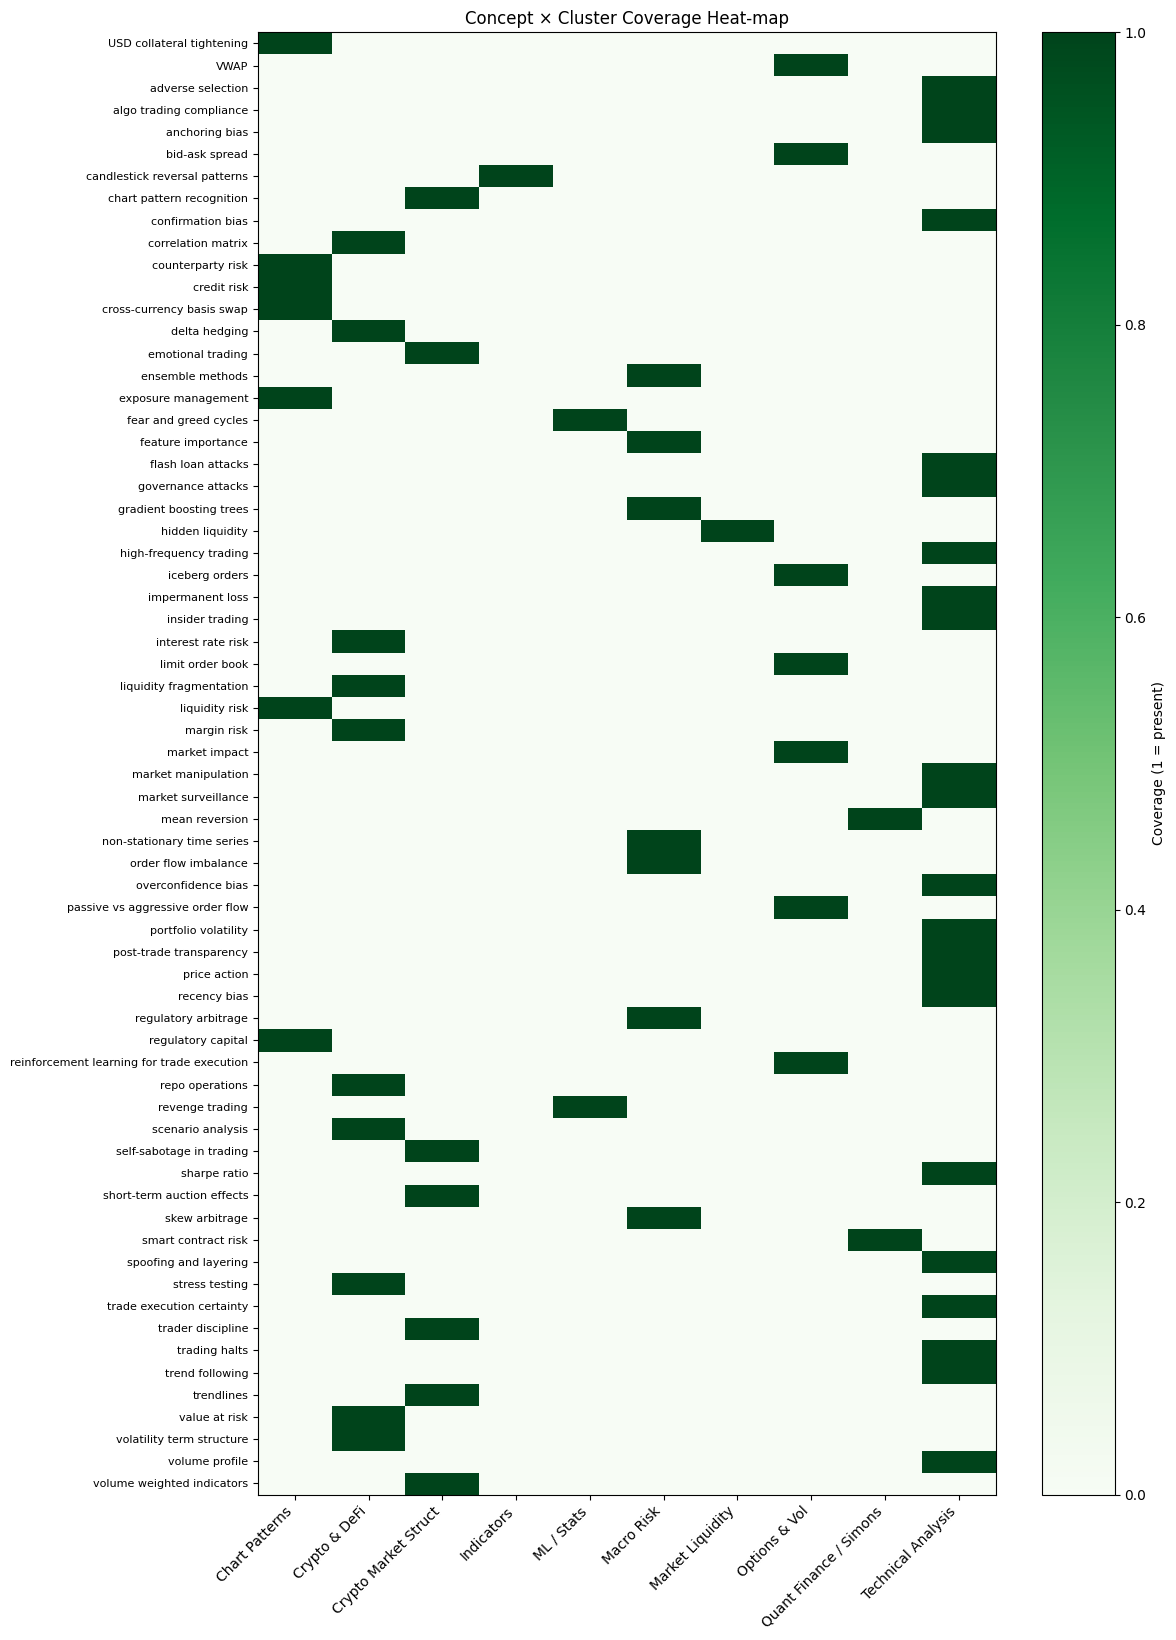

In [13]:
# ─── Heat‑map of Concept coverage by Cluster ──────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("/workspace/data/embeddings")

# 1. fresh metadata
meta_priority = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main     = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
meta_all      = pd.concat([meta_priority, meta_main], ignore_index=True)

assert "cluster_label" in meta_all.columns, "Run the cluster‑labeling cell first"

# 2. load most‑recent coverage CSV (threshold 0.65 or 0.70)
coverage_df = pd.read_csv(DATA_DIR / "concept_coverage_0p65.csv")   # change file if you ran @0.70
covered     = coverage_df[coverage_df["covered"]]

# 3. build mapping concept -> cluster (use mode cluster for that source)
rows = []
for _, row in covered.iterrows():
    src = row["source"]
    cl  = meta_all.loc[meta_all["source"] == src, "cluster_label"].mode().iloc[0]
    rows.append({"concept": row["concept"], "cluster": cl, "hit": 1})

pivot = (
    pd.DataFrame(rows)
      .pivot_table(index="concept", columns="cluster", values="hit", fill_value=0)
      .sort_index()
)

# 4. plot matrix
plt.figure(figsize=(12, max(6, 0.25 * len(pivot))))
plt.imshow(pivot.values, cmap="Greens", aspect="auto")
plt.colorbar(label="Coverage (1 = present)")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot.index)), pivot.index, fontsize=8)
plt.title("Concept × Cluster Coverage Heat‑map")
plt.tight_layout()
plt.show()


In [15]:
!pip install --no-cache-dir whoosh==2.7.4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [23]:
# Pinpoint the problematic chunk around row 37158
bad_row = clean_meta.iloc[37158]

print("🔍 Chunk ID:", bad_row["chunk_id"])
print("Source:", bad_row["source"])
print("Page:", bad_row["page"])
print("Text preview:")
print("="*80)
print(bad_row["text_preview"])
print("="*80)
print("Type:", type(bad_row["text_preview"]))


🔍 Chunk ID: 0
Source: 220001-The-Digital-Asset-Guide-For-Financial-Professionals-eBook-v3.pdf
Page: 1
Text preview:
THE DIGITAL ASSET DATA GUIDE FOR FINANCIAL PROFESSIONALS By Shawn Douglass and Tongtong Gong Getting...
Type: <class 'str'>


In [24]:
# ──────────────────────────────────────────────────────────────────────
#  SAFE‑MODE BM25 INDEX BUILD (WITH chunk_id FIX) – 2025‑04‑17
# ──────────────────────────────────────────────────────────────────────
from whoosh import index, fields
from whoosh.analysis import StemmingAnalyzer
from pathlib import Path
import os, pandas as pd, tqdm, time

# --- Set paths ---
DATA_DIR  = Path("/workspace/data/embeddings")
bm25_dir  = "/workspace/bm25_index"

# --- Load latest metadata ---
meta_priority = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main     = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
meta_all      = pd.concat([meta_priority, meta_main], ignore_index=True)

# --- Schema ---
schema = fields.Schema(
    chunk_id = fields.ID(stored=True, unique=True),
    content  = fields.TEXT(analyzer=StemmingAnalyzer(), phrase=False)
)

# --- Create or load index ---
if os.path.exists(bm25_dir):
    ix = index.open_dir(bm25_dir)
    print("📚  BM25 index already exists — loading from disk.")
else:
    os.mkdir(bm25_dir)
    ix = index.create_in(bm25_dir, schema)
    print("🛠  Building BM25 index (safe mode)…")

    # --- Clean + Deduplicate ---
    clean_meta = (
        meta_all
        .drop_duplicates("chunk_id")
        .dropna(subset=["chunk_id", "text_preview"])
        .assign(
            chunk_id=lambda df: df["chunk_id"].astype(str),
            text_preview=lambda df: df["text_preview"].astype(str)
        )
        .query("chunk_id != '0' and text_preview != 'nan' and text_preview.str.len() >= 15", engine="python")
    )

    print(f"Indexing {len(clean_meta):,} unique, non-empty chunks")

    # --- Write index with error-catching ---
    start = time.time()
    with ix.writer(limitmb=2048) as w:
        for _, row in tqdm.tqdm(clean_meta.iterrows(), total=len(clean_meta)):
            try:
                w.add_document(
                    chunk_id=row["chunk_id"],
                    content=row["text_preview"]
                )
            except Exception as e:
                print(f"⚠️  Skipped row {row['chunk_id']} due to: {e}")
    dur = time.time() - start
    print(f"✅  BM25 index built in {dur/60:.1f} minutes → {bm25_dir}")

# --- Verify document count ---
with ix.searcher() as s:
    print("📈  Documents indexed:", s.doc_count())


🛠  Building BM25 index (safe mode)…
Indexing 52,991 unique, non-empty chunks


100%|██████████| 52991/52991 [00:07<00:00, 6867.10it/s] 


✅  BM25 index built in 0.2 minutes → /workspace/bm25_index
📈  Documents indexed: 52991


In [27]:
from whoosh import index
bm25_dir = "/workspace/bm25_index"
ix = index.open_dir(bm25_dir)
print("📚 BM25 index loaded.")


📚 BM25 index loaded.


In [36]:
from whoosh.qparser import QueryParser
from whoosh import scoring

def hybrid_search(query, k=5, boost=0.10, bm25_k=20, dense_k=20):
    """
    Combine FAISS dense results + Whoosh BM25 using Reciprocal Rank Fusion.
    Returns: (source_tag, RRF_score, row, dense_rank, bm25_rank)
    """
    # 1. Dense retrieval
    dense_hits = semantic_search(query, k=dense_k, boost=boost)
    dense_rank = {row["chunk_id"]: rank+1 for rank, (_, _, row) in enumerate(dense_hits)}

    # 2. Sparse BM25
    qp = QueryParser("content", schema=ix.schema)
    with ix.searcher(weighting=scoring.BM25F()) as s:
        bm25_hits = s.search(qp.parse(query), limit=bm25_k)
        bm25_rank = {r["chunk_id"]: rank+1 for rank, r in enumerate(bm25_hits)}

    # 3. Reciprocal Rank Fusion
    fused = []
    all_ids = set(dense_rank.keys()) | set(bm25_rank.keys())

    for cid in all_ids:
        row = meta_all.loc[meta_all["chunk_id"] == cid]
        if row.empty:
            continue
        row = row.iloc[0]

        rd = dense_rank.get(cid, 1000)
        rb = bm25_rank.get(cid, 1000)
        rrf = 1/rd + 1/rb
        src = "priority" if row.get("is_priority", False) else "main"
        if cid not in dense_rank:
            src = "bm25_only"
        fused.append((src, rrf, row, rd, rb))

    fused.sort(key=lambda x: -x[1])
    return fused[:k]



In [37]:
def semantic_search(query, k=5, boost=0.10):
    """Priority-first dense retrieval: FAISS priority index first, fallback to main"""
    q_vec = encoder.encode([query])
    
    Dp, Ip = priority_index.search(q_vec, k)
    results = []
    for d, i in zip(Dp[0], Ip[0]):
        row = meta_priority.iloc[i]
        score = (1 - d) + boost
        results.append(("priority", score, row))

    if len(results) < k:
        Dm, Im = main_index.search(q_vec, k - len(results))
        for d, i in zip(Dm[0], Im[0]):
            row = meta_main.iloc[i]
            score = (1 - d)
            results.append(("main", score, row))

    results.sort(key=lambda x: -x[1])
    return results[:k]


In [38]:
hits = hybrid_search("VWAP execution certainty", k=5)
for src, score, row, rd, rb in hits:
    print(f"[{src}] RRF={score:.3f} | dense_rank={rd} | bm25_rank={rb} | {row['source']} p.{row['page']}")
    print("→", row['text_preview'][:100], "\n")




[priority] RRF=1.001 | dense_rank=1 | bm25_rank=1000 | The Financial Mathematics of Market Liquidity- From Optimal -- Gueant, Olivier -- Chapman & Hall-CRC financial mathematics series.pdf p.112
→ lly and in terms of the overall volume traded using VWAP
algorithms, there are only a few papers abo 

[priority] RRF=0.501 | dense_rank=2 | bm25_rank=1000 | Optimal trading strategies - quantitative approaches for -- Robert Kissell; Morton Glantz; Roberto Malamut -- 1st, First Edition, PS, 2003.pdf p.303
→ d. Second, 
for many traders their execution performance is measured against the 
VWAP benchmark. An 

[priority] RRF=0.334 | dense_rank=3 | bm25_rank=1000 | Optimal trading strategies - quantitative approaches for -- Robert Kissell; Morton Glantz; Roberto Malamut -- 1st, First Edition, PS, 2003.pdf p.299
→ VWAP Trading Strategies 
217. 
Figure 11.1 
Volume Profile 
14 
12 
10 
Percentage 
of 
Daily 
Volum 

[priority] RRF=0.251 | dense_rank=4 | bm25_rank=1000 | Optimal trading strategies 

In [39]:
test_queries = [
    "VWAP execution certainty",
    "delta hedging adjustment",
    "counterparty risk exposure",
    "smart contract risk detection",
    "volume profile breakout",
    "spoofing and layering detection",
    "market surveillance systems",
    "value at risk calculation",
    "limit order book liquidity",
    "adverse selection in crypto markets"
]

boost_values = [0.00, 0.05, 0.10, 0.15, 0.20]

print("🧪 Grid Search: Boost Tuning\n")
for boost in boost_values:
    print(f"\n🔧 boost = {boost:.2f}")
    for q in test_queries:
        hits = hybrid_search(q, k=1, boost=boost)
        src, score, row, rd, rb = hits[0]
        label = "✅" if rb < 1000 else "❌"
        print(f"{label} {q[:38]:<40} → {src:<12} RRF={score:.3f}  dense={rd}  bm25={rb}")


🧪 Grid Search: Boost Tuning


🔧 boost = 0.00
❌ VWAP execution certainty                 → priority     RRF=1.001  dense=1  bm25=1000
❌ delta hedging adjustment                 → priority     RRF=1.001  dense=1  bm25=1000
✅ counterparty risk exposure               → bm25_only    RRF=1.001  dense=1000  bm25=1
✅ smart contract risk detection            → priority     RRF=1.500  dense=2  bm25=1
✅ volume profile breakout                  → priority     RRF=1.050  dense=20  bm25=1
✅ spoofing and layering detection          → bm25_only    RRF=1.001  dense=1000  bm25=1
✅ market surveillance systems              → priority     RRF=1.333  dense=1  bm25=3
❌ value at risk calculation                → priority     RRF=1.001  dense=1  bm25=1000
✅ limit order book liquidity               → priority     RRF=1.167  dense=1  bm25=6
❌ adverse selection in crypto markets      → priority     RRF=1.001  dense=1  bm25=1000

🔧 boost = 0.05
❌ VWAP execution certainty                 → priority     RRF=1.001  d

In [43]:
# ───────────────────────────────────────────────────────────────
# Build Q&A prompt dataset (one chunk per concept)
# Output: qa_tasks.jsonl → used for LLM-based generation
# ───────────────────────────────────────────────────────────────
import json, pandas as pd
from pathlib import Path

# Load concept coverage file
coverage_df = pd.read_csv(DATA_DIR / "concept_coverage_0p65.csv")
covered = coverage_df[coverage_df["covered"] == True].copy()

qa_tasks = []

# For each concept, pull best chunk from hybrid search
for _, row in covered.iterrows():
    concept = row["concept"]
    hits = hybrid_search(concept, k=1, boost=0.15)
    if not hits:
        continue
    _, _, chunk, _, _ = hits[0]
    
    qa_tasks.append({
        "concept": concept,
        "source": str(chunk["source"]),
        "page": int(chunk["page"]),
        "chunk_id": str(chunk["chunk_id"]),
        "text": str(chunk["text_preview"])
    })

# Save to JSONL
prompt_path = DATA_DIR / "qa_tasks.jsonl"
with open(prompt_path, "w") as f:
    for task in qa_tasks:
        f.write(json.dumps(task) + "\n")

print(f"✅ Generated {len(qa_tasks)} concept–chunk prompt pairs → {prompt_path}")


✅ Generated 66 concept–chunk prompt pairs → /workspace/data/embeddings/qa_tasks.jsonl


In [45]:
import json
from pathlib import Path

questions_dir = Path("/workspace/data/embeddings/questions")
output_path   = questions_dir / "qa_bank_master.jsonl"

# Find all .jsonl files
jsonl_files = sorted(questions_dir.glob("qa_bank_*.jsonl"))

total = 0
with open(output_path, "w") as out:
    for file in jsonl_files:
        with open(file, "r") as f:
            for line in f:
                line = line.strip()
                if line:
                    out.write(line + "\n")
                    total += 1

print(f"✅ Merged {len(jsonl_files)} files into qa_bank_master.jsonl ({total} questions)")


✅ Merged 11 files into qa_bank_master.jsonl (83 questions)


In [46]:
import pandas as pd

master_jsonl = questions_dir / "qa_bank_master.jsonl"
master_csv   = questions_dir / "qa_bank_master.csv"

qa_data = [json.loads(line) for line in open(master_jsonl)]
df = pd.DataFrame(qa_data)
df.to_csv(master_csv, index=False)

print(f"📄 Saved master CSV with {len(df)} questions → {master_csv}")


📄 Saved master CSV with 83 questions → /workspace/data/embeddings/questions/qa_bank_master.csv


In [47]:
import pandas as pd

master_jsonl = questions_dir / "qa_bank_master.jsonl"
master_csv   = questions_dir / "qa_bank_master.csv"

qa_data = [json.loads(line) for line in open(master_jsonl)]
df = pd.DataFrame(qa_data)
df.to_csv(master_csv, index=False)

print(f"📄 Saved master CSV with {len(df)} questions → {master_csv}")



📄 Saved master CSV with 83 questions → /workspace/data/embeddings/questions/qa_bank_master.csv


In [48]:
import pandas as pd

qa_csv_path = "/workspace/data/embeddings/questions/qa_bank_master.csv"
df = pd.read_csv(qa_csv_path)

# Basic structure check
print("✅ Questions:", len(df))
print("🧠 Concepts:", df['concept'].nunique())
print("📄 Sample:")
display(df.sample(3))

# Check for missing values
print("\n🚨 Rows with missing values:")
display(df[df.isna().any(axis=1)])


✅ Questions: 83
🧠 Concepts: 11
📄 Sample:


,concept,question,answer
19,bid-ask spread and order placement,How might the shape of the execution probabili...,The execution probability curve reveals inform...
80,VWAP confidence intervals and execution quality,Compare and contrast the implications of the 6...,The progression from 67% to 90% to 95% confide...
10,auction theory and short covering,Explain how traders can identify the moment wh...,Traders can identify this pivotal transition p...



🚨 Rows with missing values:


,concept,question,answer


In [49]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

def score_response(ground_truth, ai_answer):
    emb_gt = model.encode(ground_truth, convert_to_tensor=True)
    emb_ai = model.encode(ai_answer, convert_to_tensor=True)
    return float(util.cos_sim(emb_gt, emb_ai))

# Sample comparison (change row number if desired)
row = df.sample(1).iloc[0]
print("📌 Question:", row['question'])
print("✅ True Answer:", row['answer'])

# Replace with the LLM or bot's answer here 👇
ai_answer = "VWAP confidence intervals help traders set realistic price expectations based on historical volatility."

score = score_response(row['answer'], ai_answer)
print(f"\n🧠 Semantic similarity score: {score:.3f}")


📌 Question: Compare and contrast the impact of liquidity fragmentation across different asset classes, explaining why certain markets experience more severe shadow-spread effects than others.
✅ True Answer: Liquidity fragmentation impacts asset classes differently based on their structural characteristics. Equities experience the most severe shadow-spread effects due to proliferation of alternative trading systems, maker-taker pricing models incentivizing order routing based on rebates rather than execution quality, and high order-to-trade ratios enabling sophisticated queue positioning strategies. Foreign exchange markets show moderate fragmentation effects, primarily in the EBS/Reuters duopoly and emerging non-bank liquidity providers, but lasting relationships and risk transfer mechanisms mitigate some shadow-spread widening. Fixed income markets demonstrate limited but growing fragmentation impacts, with MTS/BrokerTec/Brokertec division in sovereigns and MarketAxess/Tradeweb compet

In [50]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
qa_df = pd.read_csv("/workspace/data/embeddings/questions/qa_bank_master.csv")

# 🔁 Placeholder: replace this with your agent/model response logic
def get_ai_response(question):
    # Example — plug in your retrieval/LLM system here
    return "Liquidity fragmentation varies by asset class..."

def score_pair(true_answer, ai_answer):
    a = model.encode(true_answer, convert_to_tensor=True)
    b = model.encode(ai_answer, convert_to_tensor=True)
    return float(util.cos_sim(a, b))

# Run eval
results = []
for _, row in qa_df.iterrows():
    q, a_true = row["question"], row["answer"]
    a_ai = get_ai_response(q)
    score = score_pair(a_true, a_ai)
    results.append({
        "concept": row["concept"],
        "question": q,
        "true_answer": a_true,
        "ai_answer": a_ai,
        "similarity_score": score
    })

# Save
eval_df = pd.DataFrame(results)
eval_path = "/workspace/data/embeddings/questions/qa_eval_results.csv"
eval_df.to_csv(eval_path, index=False)
print(f"✅ Evaluation complete. Results saved to {eval_path}")


✅ Evaluation complete. Results saved to /workspace/data/embeddings/questions/qa_eval_results.csv


In [51]:
import pandas as pd

eval_path = "/workspace/data/embeddings/questions/qa_eval_results.csv"
eval_df = pd.read_csv(eval_path)

print("✅ Evaluation results loaded:")
print(f"📊 Total questions: {len(eval_df)}")
print(f"🧠 Unique concepts: {eval_df['concept'].nunique()}")
display(eval_df.sample(3))


✅ Evaluation results loaded:
📊 Total questions: 83
🧠 Unique concepts: 11


,concept,question,true_answer,ai_answer,similarity_score
36,limit order book execution probabilities,What statistical methods would be most appropr...,"Survival analysis, logistic regression with pr...",Liquidity fragmentation varies by asset class...,0.209908
28,iceberg orders and execution priority,Evaluate how the implementation of iceberg ord...,Iceberg orders produce complex effects on mark...,Liquidity fragmentation varies by asset class...,0.428198
60,liquidity fragmentation and shadow spread,Evaluate the effectiveness of regulatory initi...,Regulatory initiatives addressing fragmentatio...,Liquidity fragmentation varies by asset class...,0.456650


In [52]:
# Quick summary stats
print("📈 Mean Similarity Score:", eval_df["similarity_score"].mean())

# Score buckets
buckets = pd.cut(eval_df["similarity_score"], bins=[0, 0.3, 0.5, 0.7, 0.85, 1.0])
summary = eval_df.groupby(buckets)["similarity_score"].agg(["count", "mean"])
print("\n🔍 Score Distribution:")
display(summary)


📈 Mean Similarity Score: 0.3158417203385069

🔍 Score Distribution:


/tmp/ipykernel_2096/2888851512.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = eval_df.groupby(buckets)["similarity_score"].agg(["count", "mean"])


,count,mean
similarity_score,,
"(0.0, 0.3]",40,0.212895
"(0.3, 0.5]",36,0.384714
"(0.5, 0.7]",7,0.549904
"(0.7, 0.85]",0,NaN
"(0.85, 1.0]",0,NaN
